In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.its.dal.ca/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
# !ls
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install spark_sklearn

     |████████████████████████████████| 4.9MB 21.8MB/s 
  Created wheel for spark-sklearn: filename=spark_sklearn-0.3.0-cp36-none-any.whl size=30592 sha256=a34df79dc7ea50972dcd730f325f3c2cbf8c8cffccd67b69c54455e40d17ba4c
  Stored in directory: /root/.cache/pip/wheels/64/28/e8/cb0250888675c630786f932dcc63ed96ac1aca299bcfb7235f
Successfully built spark-sklearn
ERROR: yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
ERROR: imbalanced-learn 0.4.3 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
  Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [5]:
#import library

import time
from scipy import stats
import pyspark
from pyspark import SparkContext, SparkConf
sc = pyspark.SparkContext()
import os
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
training = pd.read_csv("/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/Dataset/training/trainingSet_noEmpty.csv")
testing = pd.read_csv("/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/Dataset/testing/testingSet_noEmpty.csv")

print(training.shape)
print(training.columns)
print()
print(testing.shape)
print(testing.columns)

(2690, 123)
Index(['Spanish Div', 'Year', 'Month', 'Day', 'FTHG', 'FTAG', 'HTHG', 'HTAG',
       'HS', 'AS',
       ...
       'AwayTeam_Sociedad', 'AwayTeam_Sp Gijon', 'AwayTeam_Valencia',
       'AwayTeam_Valladolid', 'AwayTeam_Vallecano', 'AwayTeam_Villarreal',
       'HTR_A', 'HTR_D', 'HTR_H', 'FTR'],
      dtype='object', length=123)

(1140, 123)
Index(['Spanish Div', 'Year', 'Month', 'Day', 'FTHG', 'FTAG', 'HTHG', 'HTAG',
       'HS', 'AS',
       ...
       'AwayTeam_Sociedad', 'AwayTeam_Sp Gijon', 'AwayTeam_Valencia',
       'AwayTeam_Valladolid', 'AwayTeam_Vallecano', 'AwayTeam_Villarreal',
       'HTR_A', 'HTR_D', 'HTR_H', 'FTR'],
      dtype='object', length=123)


In [0]:
# Reorder the column in test set so that columns order in both training and testing set can remain consistent
testing = testing[training.columns.values]

In [0]:
# convert back those attribute to int

training[['Spanish Div','Year','Month','Day','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
         'HR','AR']] = training[['Spanish Div','Year','Month','Day','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
         'HR','AR']].astype(int)

testing[['Spanish Div','Year','Month','Day','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
         'HR','AR']] = testing[['Spanish Div','Year','Month','Day','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
         'HR','AR']].astype(int)

In [0]:
training.iloc[:,65:122] = training.iloc[:,65:122].astype(int)
testing.iloc[:,65:122] = testing.iloc[:,65:122].astype(int)

In [0]:
training.rename(columns={"BbMx<2.5": "BbMx_less_than_2.5", "BbAv<2.5": "BbAv_less_than_2.5", "BbMx>2.5": "BbMx_more_than_2.5", "BbAv>2.5": "BbAv_more_than_2.5"},inplace = True)
testing.rename(columns={"BbMx<2.5": "BbMx_less_than_2.5", "BbAv<2.5": "BbAv_less_than_2.5", "BbMx>2.5": "BbMx_more_than_2.5", "BbAv>2.5": "BbAv_more_than_2.5"},inplace = True)

In [11]:
training.iloc[:,49:53].columns.values

array(['BbMx_more_than_2.5', 'BbAv_more_than_2.5', 'BbMx_less_than_2.5',
       'BbAv_less_than_2.5'], dtype=object)

In [12]:
testing.iloc[:,49:53].columns.values

array(['BbMx_more_than_2.5', 'BbAv_more_than_2.5', 'BbMx_less_than_2.5',
       'BbAv_less_than_2.5'], dtype=object)

In [0]:
training['FTR'] = training['FTR'].map({'A':0,'D':1,'H':2})
testing['FTR'] = testing['FTR'].map({'A':0,'D':1,'H':2})

In [14]:
print(training.shape)
print(testing.shape)

(2690, 123)
(1140, 123)


In [0]:
# lasso- feature selection
# https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499
# https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/

In [0]:
from sklearn.feature_selection import SelectFromModel
#from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
X_train = training.drop('FTAG',axis = 1)
y_train = training['FTAG']

X_test = training.drop('FTAG',axis = 1)
y_test = training['FTAG']

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
from sklearn.feature_selection import SelectFromModel
#from sklearn.linear_model import LogisticRegression
sel_ = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel_.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [20]:
feature_idx = sel_.get_support()
feature_idx

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True])

In [21]:
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
#print('features importance: {}'.format(
#     (sel_.estimator_.feature_importances_)))

total features: 122
selected features: 59


In [22]:
print(selected_feat)

Index(['Year', 'Month', 'Day', 'FTHG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST',
       'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'B365H', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA',
       'SJH', 'SJD', 'SJA', 'VCH', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD',
       'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx_more_than_2.5',
       'BbAv_more_than_2.5', 'BbMx_less_than_2.5', 'BbAv_less_than_2.5',
       'BbAH', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'PSH', 'PSD', 'PSA',
       'PSCH', 'PSCD', 'PSCA', 'HTR_A', 'FTR'],
      dtype='object')


In [23]:
feature_name = X_train.columns[feature_idx]
print(feature_name)

Index(['Year', 'Month', 'Day', 'FTHG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST',
       'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'B365H', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA',
       'SJH', 'SJD', 'SJA', 'VCH', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD',
       'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx_more_than_2.5',
       'BbAv_more_than_2.5', 'BbMx_less_than_2.5', 'BbAv_less_than_2.5',
       'BbAH', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'PSH', 'PSD', 'PSA',
       'PSCH', 'PSCD', 'PSCA', 'HTR_A', 'FTR'],
      dtype='object')


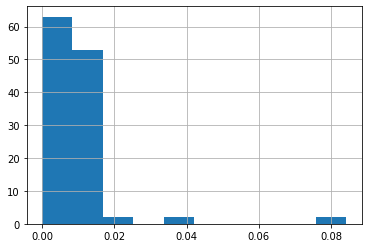

In [24]:
# Show the distibution of feature importance score of selected feature
import pandas as pd
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist()

In [25]:
#print Feature Importance Score 
feat_score = pd.DataFrame({'Feature Name': X_train.columns, 'Feature Importance Score': list(sel_.estimator_.feature_importances_)}, columns=['Feature Name', 'Feature Importance Score'])
feat_score.sort_values("Feature Importance Score", axis = 0, ascending = False, 
                 inplace = True, na_position ='last') 
feat_score.head(len(selected_feat))

Feature Name  Feature Importance Score
6                  HTAG                  0.084211
121                 FTR                  0.076140
10                  AST                  0.038451
4                  FTHG                  0.034838
118               HTR_A                  0.021823
8                    AS                  0.017333
3                   Day                  0.015969
5                  HTHG                  0.015371
11                   HF                  0.015054
62                 PSCD                  0.014863
54              BbMxAHH                  0.014791
55              BbAvAHH                  0.014772
7                    HS                  0.014513
56              BbMxAHA                  0.014451
63                 PSCA                  0.014235
60                  PSA                  0.014234
57              BbAvAHA                  0.014102
40                Bb1X2                  0.013971
61                 PSCH                  0.013818
49   BbAv_more_than_2.5                  0.013712
34                  SJH                  0.013496
12                   AF                  0.013490
59                  PSD                  0.013368
51   BbAv_less_than_2.5                  0.013093
36                  SJA                  0.013040
50   BbMx_less_than_2.5                  0.013033
47                 BbOU                  0.013020
45                BbMxA                  0.012999
48   BbMx_more_than_2.5                  0.012985
52                 BbAH                  0.012684
58                  PSH                  0.012508
9                   HST                  0.012504
44                BbAvD                  0.012277
43                BbMxD                  0.011661
41                BbMxH                  0.011616
14                   AC                  0.011478
2                 Month                  0.011382
35                  SJD                  0.011202
24                  BWA                  0.011169
13                   HC                  0.011014
46                BbAvA                  0.010955
39                  VCA                  0.010630
42                BbAvH                  0.010556
28                  LBH                  0.010394
27                  IWA                  0.010262
30                  LBA                  0.010231
29                  LBD                  0.009942
33                  WHA                  0.009867
16                   AY                  0.009606
21                B365A                  0.009397
37                  VCH                  0.009367
22                  BWH                  0.009184
1                  Year                  0.009018
32                  WHD                  0.009007
15                   HY                  0.008966
25                  IWH                  0.008832
19                B365H                  0.008735
23                  BWD                  0.008609
31                  WHH                  0.008476

In [26]:
newXtrain = X_train[feature_name]

newXtrain.shape

(2690, 59)

In [27]:
newXtest = X_test[feature_name]

newXtest.shape

(2690, 59)

In [0]:
import time
from sklearn.ensemble import RandomForestClassifier
import spark_sklearn
from spark_sklearn import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,roc_curve,auc
#import xgboost as xgb

In [0]:
def metrics_calculation(model_name,Y_true,Y_predict):
  #roc=roc_auc_score(Y_true, Y_predict)
  accuracy = accuracy_score(Y_true, Y_predict)
  precision = precision_score(Y_true, Y_predict,average=None)
  recall = recall_score(Y_true, Y_predict,average=None)
  f1 = f1_score(Y_true, Y_predict,average=None)
  metrics=  pd.DataFrame([[model_name,accuracy,precision,recall,f1]],columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
  return metrics

In [0]:
model_results = []
models = {}
confusion_matrices = []
time_results=[]

In [0]:
# Random Forest Classifier
parameters = {
    "max_depth": [3, None],
    "max_features": [1, 3, 5],
    "min_samples_split": [0.5, 0.9],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "n_estimators": [10, 20, 40, 80]
}

In [32]:
start = time.time()
gs = spark_sklearn.GridSearchCV(sc,estimator=RandomForestClassifier(), cv=5,param_grid=parameters,n_jobs=-1)
gs.fit(newXtrain, y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("RandomForestClassifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 285.2918999195099 seconds


[('RandomForestClassifier', 285.2918999195099)]

In [33]:
models['rfc'] = gs
predYtest = gs.predict(newXtest)
model_results.append(metrics_calculation('Random Forest Classifier',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.7383259911894273, 0.45458960660514813, 0.17...
 
 [1 rows x 5 columns]]

In [34]:
# confusion matrix

#confusion_matrices.append(confusion_matrix(Y_test,predYtest))
#confusion_matrices
print('Random Forest: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("RandomForestClassifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

Random Forest:  [[838  85   0   0   0   0   0   0   0]
 [448 468  21   0   0   0   0   0   0]
 [ 53 401  66   0   0   0   0   0   0]
 [  8 128  57   0   0   0   0   0   0]
 [  0  32  49   0   0   0   0   0   0]
 [  0   6  16   0   0   0   0   0   0]
 [  0   2   8   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0]
 [  0   0   3   0   0   0   0   0   0]]


[('RandomForestClassifier',
  array([[838,  85,   0,   0,   0,   0,   0,   0,   0],
         [448, 468,  21,   0,   0,   0,   0,   0,   0],
         [ 53, 401,  66,   0,   0,   0,   0,   0,   0],
         [  8, 128,  57,   0,   0,   0,   0,   0,   0],
         [  0,  32,  49,   0,   0,   0,   0,   0,   0],
         [  0,   6,  16,   0,   0,   0,   0,   0,   0],
         [  0,   2,   8,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0]]))]

In [0]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
parameters = {
    'max_depth':[2,4,6,8,10],
    'min_samples_leaf':[2,4,6,8,10], 
    'min_samples_split':[2,4,6,8,10],
    'criterion': ['gini','entropy']
}

In [36]:
start = time.time()
dt = DecisionTreeClassifier()
gs_dt = spark_sklearn.GridSearchCV(sc,estimator=dt,cv=5,param_grid=parameters,n_jobs=-1)
gs_dt.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("DecisionTreeClassifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 80.36424660682678 seconds


[('RandomForestClassifier', 285.2918999195099),
 ('DecisionTreeClassifier', 80.36424660682678)]

In [37]:
models['dt'] = gs_dt
predYtest = gs_dt.predict(newXtest)
model_results.append(metrics_calculation('Decision Tree',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.7383259911894273, 0.45458960660514813, 0.17...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.8796992481203008, 0.8022312373225151, 0.742...
 
 [1 rows x 5 columns]]

In [38]:
# confusion matrix
print('Decision Tree: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("DecisionTreeClassifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

Decision Tree:  [[819 104   0   0   0   0   0   0   0]
 [116 791  30   0   0   0   0   0   0]
 [  3 113 387   5  12   0   0   0   0]
 [  1  23  80  79  10   0   0   0   0]
 [  0   4  20  10  45   0   2   0   0]
 [  0   0   5   2  12   0   3   0   0]
 [  0   0   1   0   3   0   6   0   0]
 [  0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   2   0   1   0   0]]


[('RandomForestClassifier',
  array([[838,  85,   0,   0,   0,   0,   0,   0,   0],
         [448, 468,  21,   0,   0,   0,   0,   0,   0],
         [ 53, 401,  66,   0,   0,   0,   0,   0,   0],
         [  8, 128,  57,   0,   0,   0,   0,   0,   0],
         [  0,  32,  49,   0,   0,   0,   0,   0,   0],
         [  0,   6,  16,   0,   0,   0,   0,   0,   0],
         [  0,   2,   8,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[819, 104,   0,   0,   0,   0,   0,   0,   0],
         [116, 791,  30,   0,   0,   0,   0,   0,   0],
         [  3, 113, 387,   5,  12,   0,   0,   0,   0],
         [  1,  23,  80,  79,  10,   0,   0,   0,   0],
         [  0,   4,  20,  10,  45,   0,   2,   0,   0],
         [  0,   0,   5,   2,  12,   0,   3,   0,   0],
         [  0,   0,   1,   0,   3,   0,   6,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0, 

In [0]:
# KNN Classifier
parameters = {
    'n_neighbors': [3,5,10],
}

In [40]:
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
knn = KNeighborsClassifier()
gs_knn = spark_sklearn.GridSearchCV(sc,estimator=knn,cv=5,param_grid=parameters,n_jobs=-1)
gs_knn.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("KNeighborsClassifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 5.9483232498168945 seconds


[('RandomForestClassifier', 285.2918999195099),
 ('DecisionTreeClassifier', 80.36424660682678),
 ('KNeighborsClassifier', 5.9483232498168945)]

In [41]:
models['knn'] = gs_knn
predYtest = gs_knn.predict(newXtest)
model_results.append(metrics_calculation('KNN Classifier',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.7383259911894273, 0.45458960660514813, 0.17...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.8796992481203008, 0.8022312373225151, 0.742...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.6423963133640552, 0.5733063700707786, 0.413...
 
 [1 rows x 5 columns]]

In [42]:
# confusion matrix
print('KNN Classifier: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("Classifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

KNN Classifier:  [[697 198  21   6   0   1   0   0   0]
 [323 567  34   9   4   0   0   0   0]
 [153 188 166  10   3   0   0   0   0]
 [ 54  64  31  43   1   0   0   0   0]
 [ 12  18  22   9  20   0   0   0   0]
 [  6   5   5   1   3   2   0   0   0]
 [  2   0   4   1   1   0   2   0   0]
 [  0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   1   0   0]]


[('RandomForestClassifier',
  array([[838,  85,   0,   0,   0,   0,   0,   0,   0],
         [448, 468,  21,   0,   0,   0,   0,   0,   0],
         [ 53, 401,  66,   0,   0,   0,   0,   0,   0],
         [  8, 128,  57,   0,   0,   0,   0,   0,   0],
         [  0,  32,  49,   0,   0,   0,   0,   0,   0],
         [  0,   6,  16,   0,   0,   0,   0,   0,   0],
         [  0,   2,   8,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[819, 104,   0,   0,   0,   0,   0,   0,   0],
         [116, 791,  30,   0,   0,   0,   0,   0,   0],
         [  3, 113, 387,   5,  12,   0,   0,   0,   0],
         [  1,  23,  80,  79,  10,   0,   0,   0,   0],
         [  0,   4,  20,  10,  45,   0,   2,   0,   0],
         [  0,   0,   5,   2,  12,   0,   3,   0,   0],
         [  0,   0,   1,   0,   3,   0,   6,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0, 

In [0]:
# Logistic Regression
parameters = {
  'C': [0.001, 0.01, 0.1, 1, 10], 
  'class_weight': [None, 'balanced'], 
  'penalty': ['l1', 'l2']
}

In [44]:
from sklearn.linear_model import LogisticRegression
start = time.time()
lr = LogisticRegression()
gs_lr = spark_sklearn.GridSearchCV(sc,estimator=lr,param_grid = parameters,cv=5,n_jobs=-1)
gs_lr.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("LogisticRegression",finish - start))
time_results

Time required to do Parallel Grid Search CV: 216.09854006767273 seconds


[('RandomForestClassifier', 285.2918999195099),
 ('DecisionTreeClassifier', 80.36424660682678),
 ('KNeighborsClassifier', 5.9483232498168945),
 ('LogisticRegression', 216.09854006767273)]

In [45]:
models['lr'] = gs_lr
predYtest = gs_lr.predict(newXtest)
model_results.append(metrics_calculation('Logistic Regression',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.7383259911894273, 0.45458960660514813, 0.17...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.8796992481203008, 0.8022312373225151, 0.742...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.6423963133640552, 0.5733063700707786, 0.413...
 
 [1 rows x 5 columns],
                  Model  ...                                           F1 Score
 0  Logistic Regression  ...  [0.8416464891041162, 0.6638655462184874, 0.493...
 
 [1 rows x 5 columns]]

In [46]:
# Confusion Matrix
print('Logistic Regression: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("LogisticRegression",confusion_matrix(y_test,predYtest)))
confusion_matrices

Logistic Regression:  [[869  54   0   0   0   0   0   0   0]
 [259 632  46   0   0   0   0   0   0]
 [ 13 238 261   7   1   0   0   0   0]
 [  1  38 143   8   3   0   0   0   0]
 [  0   5  61   6   9   0   0   0   0]
 [  0   0  19   0   2   1   0   0   0]
 [  0   0   7   1   1   0   1   0   0]
 [  0   0   1   0   0   0   0   0   0]
 [  0   0   0   1   0   1   0   0   1]]


[('RandomForestClassifier',
  array([[838,  85,   0,   0,   0,   0,   0,   0,   0],
         [448, 468,  21,   0,   0,   0,   0,   0,   0],
         [ 53, 401,  66,   0,   0,   0,   0,   0,   0],
         [  8, 128,  57,   0,   0,   0,   0,   0,   0],
         [  0,  32,  49,   0,   0,   0,   0,   0,   0],
         [  0,   6,  16,   0,   0,   0,   0,   0,   0],
         [  0,   2,   8,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[819, 104,   0,   0,   0,   0,   0,   0,   0],
         [116, 791,  30,   0,   0,   0,   0,   0,   0],
         [  3, 113, 387,   5,  12,   0,   0,   0,   0],
         [  1,  23,  80,  79,  10,   0,   0,   0,   0],
         [  0,   4,  20,  10,  45,   0,   2,   0,   0],
         [  0,   0,   5,   2,  12,   0,   3,   0,   0],
         [  0,   0,   1,   0,   3,   0,   6,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0, 

In [0]:
# SGD
parameters = {
  'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0], 
  'class_weight': [None, 'balanced']
}

In [48]:
from sklearn.linear_model import SGDClassifier
start = time.time()
sgd = SGDClassifier(loss="hinge")
gs_sgd = spark_sklearn.GridSearchCV(sc,estimator=sgd,param_grid = parameters,cv=5,n_jobs=-1)
gs_sgd.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("SGD Classifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 4.169855117797852 seconds


[('RandomForestClassifier', 285.2918999195099),
 ('DecisionTreeClassifier', 80.36424660682678),
 ('KNeighborsClassifier', 5.9483232498168945),
 ('LogisticRegression', 216.09854006767273),
 ('SGD Classifier', 4.169855117797852)]

In [49]:
models['sgd'] = gs_sgd
predYtest = gs_sgd.predict(newXtest)
model_results.append(metrics_calculation('SGD',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.7383259911894273, 0.45458960660514813, 0.17...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.8796992481203008, 0.8022312373225151, 0.742...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.6423963133640552, 0.5733063700707786, 0.413...
 
 [1 rows x 5 columns],
                  Model  ...                                           F1 Score
 0  Logistic Regression  ...  [0.8416464891041162, 0.6638655462184874, 0.493...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SGD  ...  [0.5109327428729588, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 
 [1 rows x 5 columns]]

In [50]:
# Confusion Matrix
print('SGD: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("SGD Classifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

SGD:  [[923   0   0   0   0   0   0   0   0]
 [937   0   0   0   0   0   0   0   0]
 [520   0   0   0   0   0   0   0   0]
 [193   0   0   0   0   0   0   0   0]
 [ 81   0   0   0   0   0   0   0   0]
 [ 22   0   0   0   0   0   0   0   0]
 [ 10   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0   0   0]]


[('RandomForestClassifier',
  array([[838,  85,   0,   0,   0,   0,   0,   0,   0],
         [448, 468,  21,   0,   0,   0,   0,   0,   0],
         [ 53, 401,  66,   0,   0,   0,   0,   0,   0],
         [  8, 128,  57,   0,   0,   0,   0,   0,   0],
         [  0,  32,  49,   0,   0,   0,   0,   0,   0],
         [  0,   6,  16,   0,   0,   0,   0,   0,   0],
         [  0,   2,   8,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[819, 104,   0,   0,   0,   0,   0,   0,   0],
         [116, 791,  30,   0,   0,   0,   0,   0,   0],
         [  3, 113, 387,   5,  12,   0,   0,   0,   0],
         [  1,  23,  80,  79,  10,   0,   0,   0,   0],
         [  0,   4,  20,  10,  45,   0,   2,   0,   0],
         [  0,   0,   5,   2,  12,   0,   3,   0,   0],
         [  0,   0,   1,   0,   3,   0,   6,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0, 

In [0]:
# SVM (rbf)
parameters = [
   {'kernel': ['rbf'], 
    'gamma': [ 1, 1e-2, 1e-4],
    'C': [1, 10, 100]
   },
]

In [52]:
from sklearn import svm
start = time.time()
svc = svm.SVC(probability=True)
gs_svc = spark_sklearn.GridSearchCV(sc,estimator=svc,param_grid = parameters,cv=5,n_jobs=-1)
gs_svc.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("SVM",finish - start))
time_results

Time required to do Parallel Grid Search CV: 197.26914358139038 seconds


[('RandomForestClassifier', 285.2918999195099),
 ('DecisionTreeClassifier', 80.36424660682678),
 ('KNeighborsClassifier', 5.9483232498168945),
 ('LogisticRegression', 216.09854006767273),
 ('SGD Classifier', 4.169855117797852),
 ('SVM', 197.26914358139038)]

In [53]:
models['svm'] = gs_svc
redYtest = gs_svc.predict(newXtest)
model_results.append(metrics_calculation('SVM',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.7383259911894273, 0.45458960660514813, 0.17...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.8796992481203008, 0.8022312373225151, 0.742...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.6423963133640552, 0.5733063700707786, 0.413...
 
 [1 rows x 5 columns],
                  Model  ...                                           F1 Score
 0  Logistic Regression  ...  [0.8416464891041162, 0.6638655462184874, 0.493...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SGD  ...  [0.5109327428729588, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SVM  ...  [0.5109327428729588, 0.0, 0.0, 0.0, 0

In [54]:
# Confusion Matrix
print('SVM: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("SVM Classifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

SVM:  [[923   0   0   0   0   0   0   0   0]
 [937   0   0   0   0   0   0   0   0]
 [520   0   0   0   0   0   0   0   0]
 [193   0   0   0   0   0   0   0   0]
 [ 81   0   0   0   0   0   0   0   0]
 [ 22   0   0   0   0   0   0   0   0]
 [ 10   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0   0   0]]


[('RandomForestClassifier',
  array([[838,  85,   0,   0,   0,   0,   0,   0,   0],
         [448, 468,  21,   0,   0,   0,   0,   0,   0],
         [ 53, 401,  66,   0,   0,   0,   0,   0,   0],
         [  8, 128,  57,   0,   0,   0,   0,   0,   0],
         [  0,  32,  49,   0,   0,   0,   0,   0,   0],
         [  0,   6,  16,   0,   0,   0,   0,   0,   0],
         [  0,   2,   8,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[819, 104,   0,   0,   0,   0,   0,   0,   0],
         [116, 791,  30,   0,   0,   0,   0,   0,   0],
         [  3, 113, 387,   5,  12,   0,   0,   0,   0],
         [  1,  23,  80,  79,  10,   0,   0,   0,   0],
         [  0,   4,  20,  10,  45,   0,   2,   0,   0],
         [  0,   0,   5,   2,  12,   0,   3,   0,   0],
         [  0,   0,   1,   0,   3,   0,   6,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0, 

In [0]:
#XGBoost
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
#https://www.datacamp.com/community/tutorials/xgboost-in-python

parameters = [
    {'objective': ['reg:logistic'],
     'learning_rate': [0.01, 0.05, 0.1],
     'n_estimators': [10, 20, 40, 80],
     'max_depth': [3,5,10],
     'gamma': [1,3,5,10],
     'colsample_bytree': [0.3, 0.5, 0.8]},
]

In [56]:
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
#from sklearn.cross_validation import *
from sklearn.model_selection import GridSearchCV

start = time.time()
xgb_model = xgb.XGBClassifier()
#gs_xgbc = spark_sklearn.GridSearchCV(sc,estimator=xgbc,param_grid = parameters,cv=5,n_jobs=-1)
xgbc = GridSearchCV(estimator=xgb_model,param_grid = parameters,cv=5,n_jobs=-1)
xgbc.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("XGBoost Classifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 2144.642624616623 seconds


[('RandomForestClassifier', 285.2918999195099),
 ('DecisionTreeClassifier', 80.36424660682678),
 ('KNeighborsClassifier', 5.9483232498168945),
 ('LogisticRegression', 216.09854006767273),
 ('SGD Classifier', 4.169855117797852),
 ('SVM', 197.26914358139038),
 ('XGBoost Classifier', 2144.642624616623)]

In [57]:
models['xgbc'] = xgbc
predYtest = xgbc.predict(newXtest)
model_results.append(metrics_calculation('XGBC',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.7383259911894273, 0.45458960660514813, 0.17...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.8796992481203008, 0.8022312373225151, 0.742...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.6423963133640552, 0.5733063700707786, 0.413...
 
 [1 rows x 5 columns],
                  Model  ...                                           F1 Score
 0  Logistic Regression  ...  [0.8416464891041162, 0.6638655462184874, 0.493...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SGD  ...  [0.5109327428729588, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SVM  ...  [0.5109327428729588, 0.0, 0.0, 0.0, 0

In [58]:
# Confusion Matrix
print('XGBC: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("XGBoost Classifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

XGBC:  [[919   4   0   0   0   0   0   0   0]
 [155 769  13   0   0   0   0   0   0]
 [ 20  87 413   0   0   0   0   0   0]
 [  3  18  83  89   0   0   0   0   0]
 [  0   4  32  20  25   0   0   0   0]
 [  0   0   8   7   7   0   0   0   0]
 [  0   0   2   2   6   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   3   0   0   0   0]]


[('RandomForestClassifier',
  array([[838,  85,   0,   0,   0,   0,   0,   0,   0],
         [448, 468,  21,   0,   0,   0,   0,   0,   0],
         [ 53, 401,  66,   0,   0,   0,   0,   0,   0],
         [  8, 128,  57,   0,   0,   0,   0,   0,   0],
         [  0,  32,  49,   0,   0,   0,   0,   0,   0],
         [  0,   6,  16,   0,   0,   0,   0,   0,   0],
         [  0,   2,   8,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[819, 104,   0,   0,   0,   0,   0,   0,   0],
         [116, 791,  30,   0,   0,   0,   0,   0,   0],
         [  3, 113, 387,   5,  12,   0,   0,   0,   0],
         [  1,  23,  80,  79,  10,   0,   0,   0,   0],
         [  0,   4,  20,  10,  45,   0,   2,   0,   0],
         [  0,   0,   5,   2,  12,   0,   3,   0,   0],
         [  0,   0,   1,   0,   3,   0,   6,   0,   0],
         [  0,   0,   0,   0,   1,   0,   0, 

In [59]:
# combine dataframes, each dataframe store the metrics of each classifier

df1 = pd.DataFrame(model_results[0])
df2 = pd.DataFrame(model_results[1])
df3 = pd.DataFrame(model_results[2])
df4 = pd.DataFrame(model_results[3])
df5 = pd.DataFrame(model_results[4])
df6 = pd.DataFrame(model_results[5])
df7 = pd.DataFrame(model_results[6])
frames = [df1, df2, df3, df4, df5, df6, df7]
result = pd.concat(frames)
result

Model  ...                                           F1 Score
0  Random Forest Classifier  ...  [0.7383259911894273, 0.45458960660514813, 0.17...
0             Decision Tree  ...  [0.8796992481203008, 0.8022312373225151, 0.742...
0            KNN Classifier  ...  [0.6423963133640552, 0.5733063700707786, 0.413...
0       Logistic Regression  ...  [0.8416464891041162, 0.6638655462184874, 0.493...
0                       SGD  ...  [0.5109327428729588, 0.0, 0.0, 0.0, 0.0, 0.0, ...
0                       SVM  ...  [0.5109327428729588, 0.0, 0.0, 0.0, 0.0, 0.0, ...
0                      XGBC  ...  [0.9099009900990099, 0.845519516217702, 0.7712...

[7 rows x 5 columns]

No handles with labels found to put in legend.


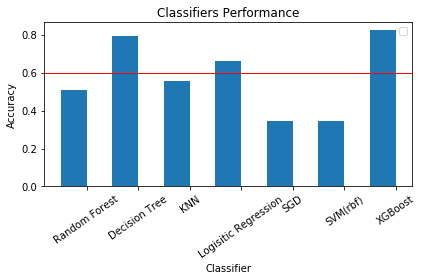

In [60]:
# plot accuracy bar chart

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Random Forest', 'Decision Tree', 'KNN', 'Logisitic Regression', 'SGD', 'SVM(rbf)', 'XGBoost']
accuracy = result['Accuracy']

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Classifier')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation = 35)
ax.set_title('Classifiers Performance')
ax.legend()

plt.axhline(y=0.6,linewidth=1, color='r')

fig.tight_layout()

plt.show()